In [1]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
dataset

Processing...
Done!


Cora()

In [4]:
print(len(dataset))
print(dataset.num_node_features)
print(dataset.num_edge_features)
print(dataset.num_classes)

1
1433
0
7


In [5]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [7]:
print(data.num_node_features)
print(data.num_edge_features)
print(data.is_undirected())
print(data.has_self_loops())
print(data.has_isolated_nodes())

1433
0
True
False
False


In [9]:
print(f"number of training nodes:{data.train_mask.sum()}")
print(f"Training node labe rate: {int(data.train_mask.sum())/(data.num_nodes):.2f}")

number of training nodes:140
Training node labe rate: 0.05


In [12]:
print(data.x.shape)
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [13]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [15]:
print(len(data.test_mask)==data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [16]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [17]:
import torch
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
import torch.nn. functional as F
from torch.nn import CrossEntropyLoss


In [25]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training =self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        out = self.lin(x)
        out = F.softmax(out, dim=1)

        return out

model = GNN(hidden_channels=64)
# model
print(model)

GNN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=7, bias=True)
)


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

In [28]:
learning_rate = 0.007
weight_decay = 5e-4

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = CrossEntropyLoss()

In [29]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct_val = pred[data.test_mask]==data.y[data.test_mask]
    test_acc = int(correct_val.sum())/int(data.test_mask.sum())
    return test_acc

In [31]:
epochs =1000
losses = []
for i in range(epochs):
    loss = train()
    losses.append(loss)
    if i%100==0:
        print(f"epoch: {i+1: 03d} and loss: {loss:.4f}")

epoch:  01 and loss: 1.5346
epoch:  101 and loss: 1.2991
epoch:  201 and loss: 1.2613
epoch:  301 and loss: 1.2285
epoch:  401 and loss: 1.2057
epoch:  501 and loss: 1.2084
epoch:  601 and loss: 1.2138
epoch:  701 and loss: 1.2053
epoch:  801 and loss: 1.2073
epoch:  901 and loss: 1.1876


In [37]:
import warnings
warnings.filterwarnings("ignore")

<AxesSubplot:>

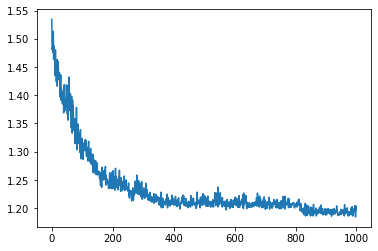

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_index = [i for i, l in enumerate(losses_float)]
plt1 = sns.lineplot(loss_index, losses_float)
plt1

In [39]:
test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7030


torch.Size([2708, 7])


<AxesSubplot:>

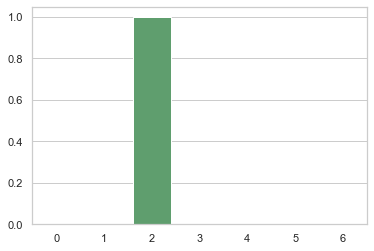

In [43]:
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].cpu().detach().numpy())

In [44]:
from sklearn.manifold import TSNE

In [45]:
def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr
def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f"Epoch: {epoch}")
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color.detach().cpu().numpy(), cmap='Set2')

    fig.canvas.draw()
    return plt2arr(fig)
    
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

TSNE Visualization finished.


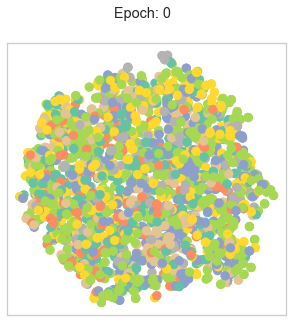

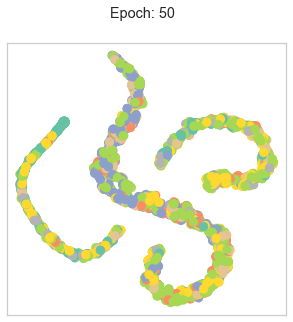

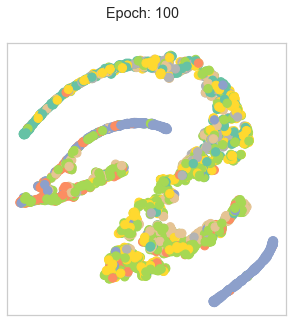

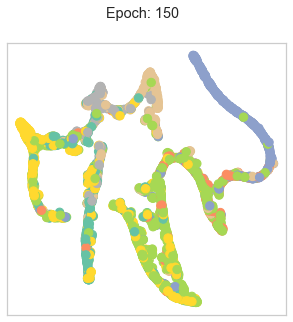

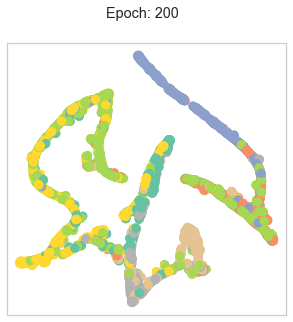

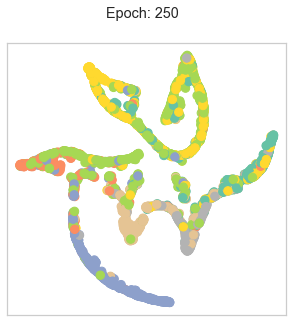

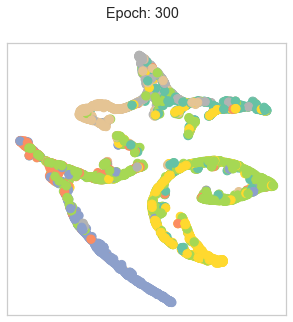

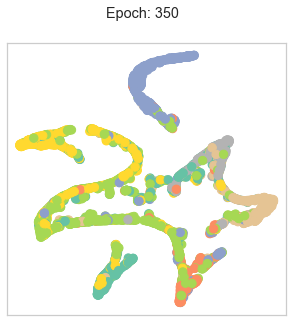

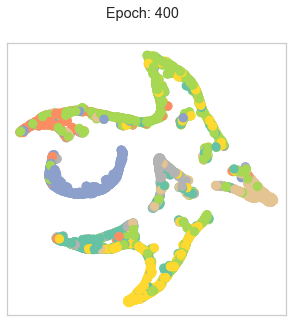

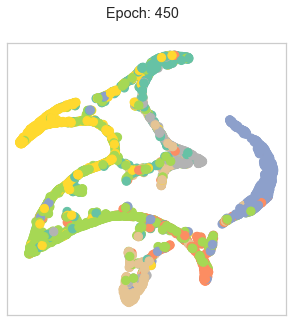

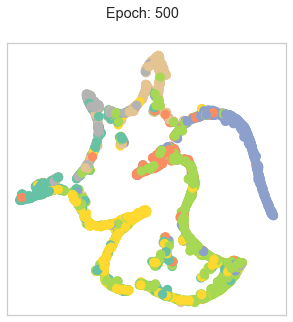

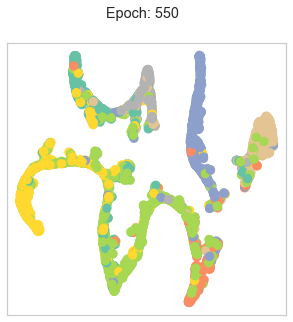

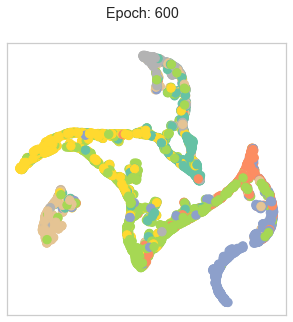

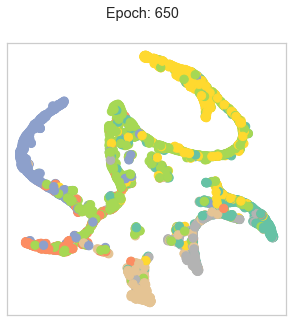

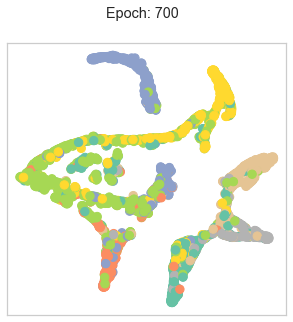

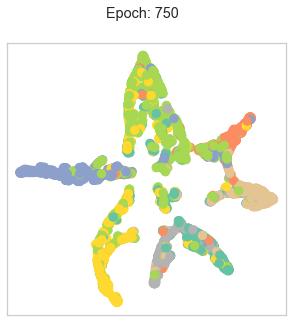

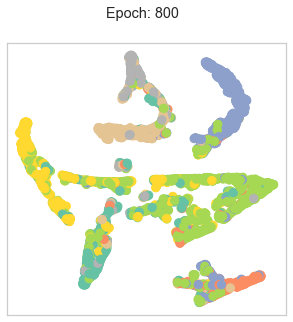

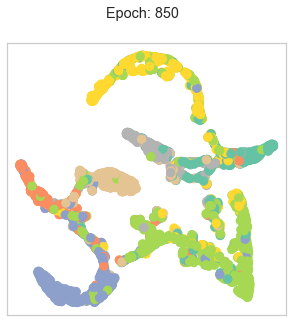

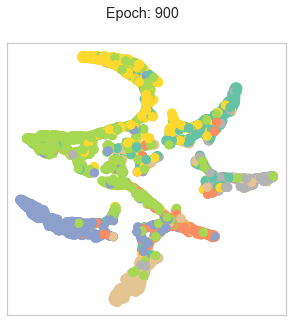

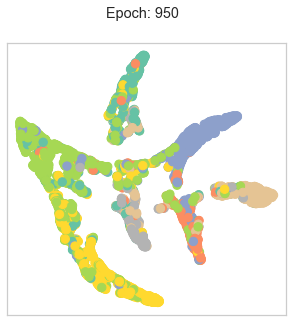

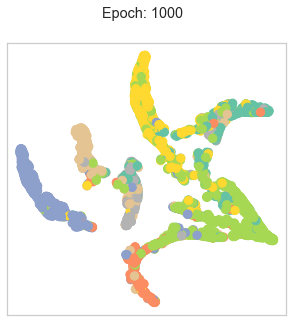

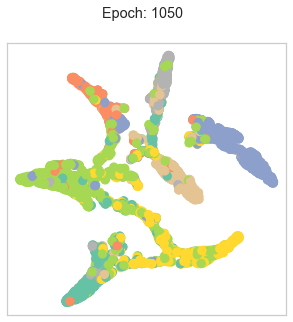

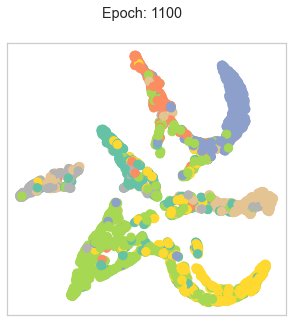

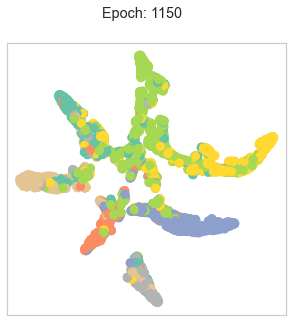

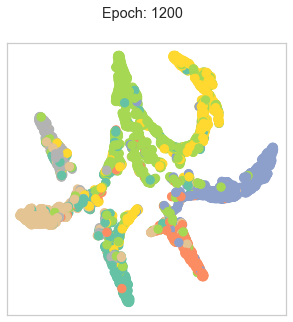

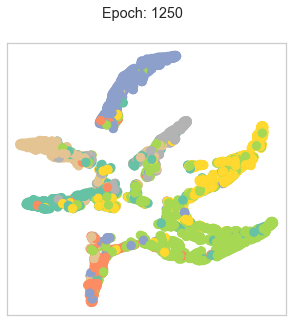

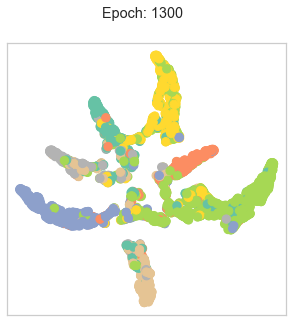

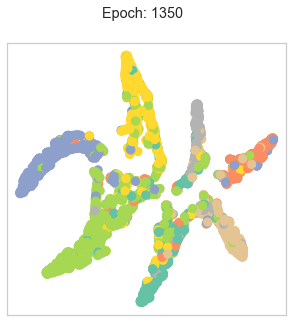

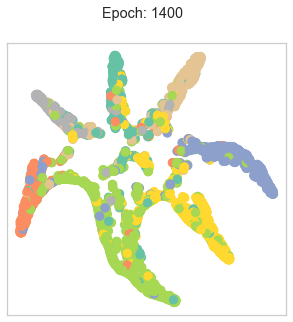

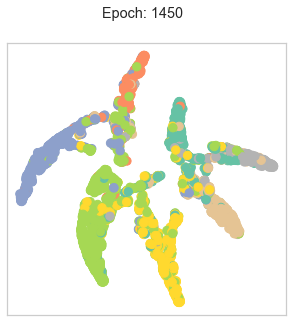

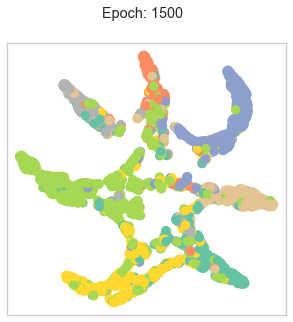

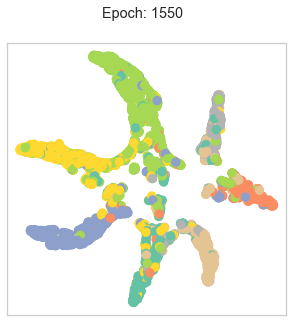

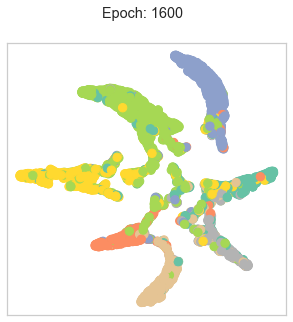

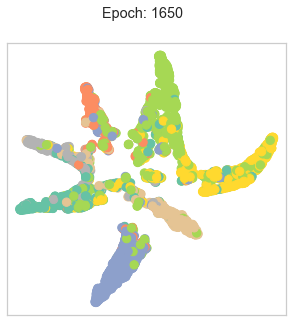

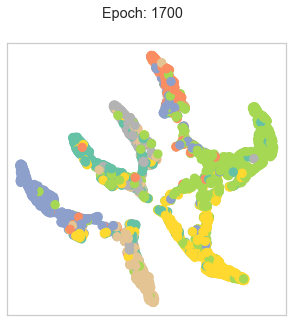

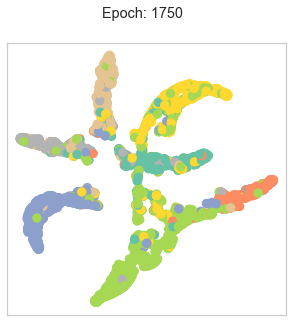

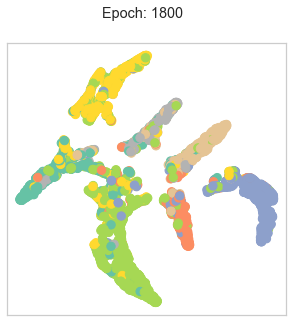

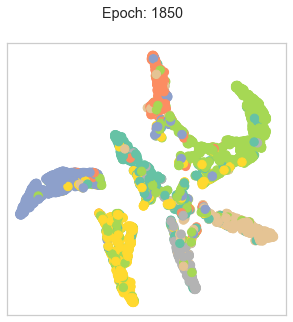

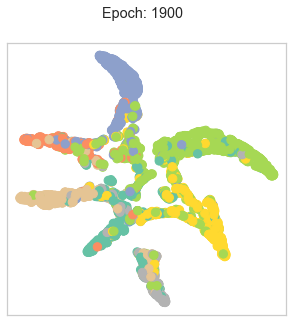

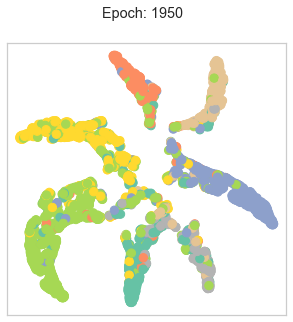

In [46]:
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

In [50]:
from moviepy.editor import ImageSequenceClip
fps =1
filename = "C:\Users\Administrator\Documents\GNN_visualize\embeddings.gif"
clip = ImageSequenceClip(images, fps)
clip.write_gif(filename, fps)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2981011705.py, line 3)

In [51]:
from IPython.display import Image
with open(filename, "rb") as f:
    display(Image(f.read(), format='png'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/embeddings.gif'